# Bank marketing data exploration

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from wordcloud import WordCloud

## Loading data

In [64]:
data = pd.read_csv('../../datasets/bank.csv', sep=";")
data.head(10)

age            job  marital  education default  balance housing loan  \
0   30     unemployed  married    primary      no     1787      no   no   
1   33       services  married  secondary      no     4789     yes  yes   
2   35     management   single   tertiary      no     1350     yes   no   
3   30     management  married   tertiary      no     1476     yes  yes   
4   59    blue-collar  married  secondary      no        0     yes   no   
5   35     management   single   tertiary      no      747      no   no   
6   36  self-employed  married   tertiary      no      307     yes   no   
7   39     technician  married  secondary      no      147     yes   no   
8   41   entrepreneur  married   tertiary      no      221     yes   no   
9   43       services  married    primary      no      -88     yes  yes   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  
5  cellular   23   feb       141         2    176         3  failure  no  
6  cellular   14   may       341         1    330         2    other  no  
7  cellular    6   may       151         2     -1         0  unknown  no  
8   unknown   14   may        57         2     -1         0  unknown  no  
9  cellular   17   apr       313         1    147         2  failure  no

## Formal exploration

In [3]:
# dataset shape
data.shape

(4521, 17)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object 

Object features uniques count
job            :  12
marital        :  3
education      :  4
default        :  2
housing        :  2
loan           :  2
contact        :  3
month          :  12
poutcome       :  4
y              :  2


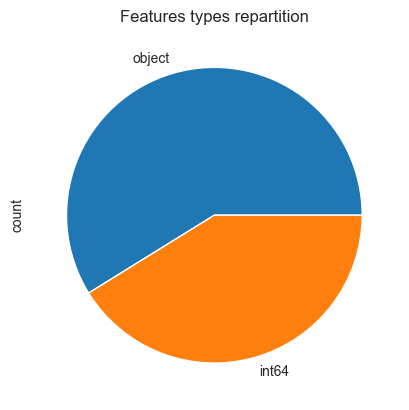

In [4]:
# features types
print(data.dtypes, '\n')
plt.figure()
data.dtypes.value_counts().plot.pie()
plt.title('Features types repartition')

print('Object features uniques count')
for obj_col in data.select_dtypes('object') :
    print(f"{f'{obj_col}' : <14} : ", len(data[obj_col].unique()))

Text(0.5, 1.0, 'Missing values')

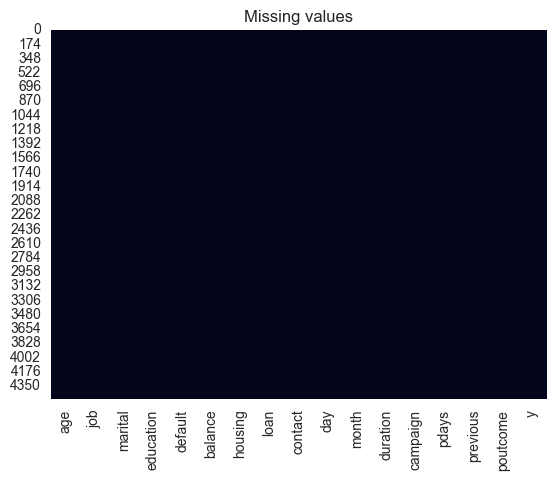

In [5]:
# missing values
sns.heatmap(data.isna(), cbar=False)
plt.title("Missing values")

## Deep exploration

<Axes: ylabel='count'>

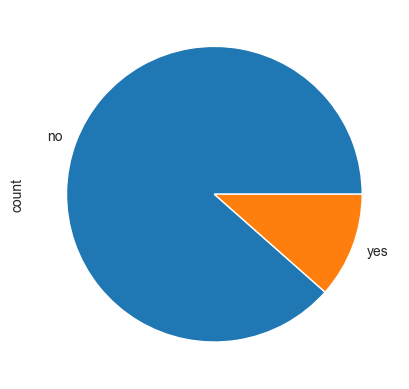

In [6]:
# target visualization
data.y.value_counts().plot.pie()

In [8]:
data_enc = data.copy()
data_enc = pd.DataFrame(OrdinalEncoder().fit_transform(data_enc), columns=data_enc.columns)

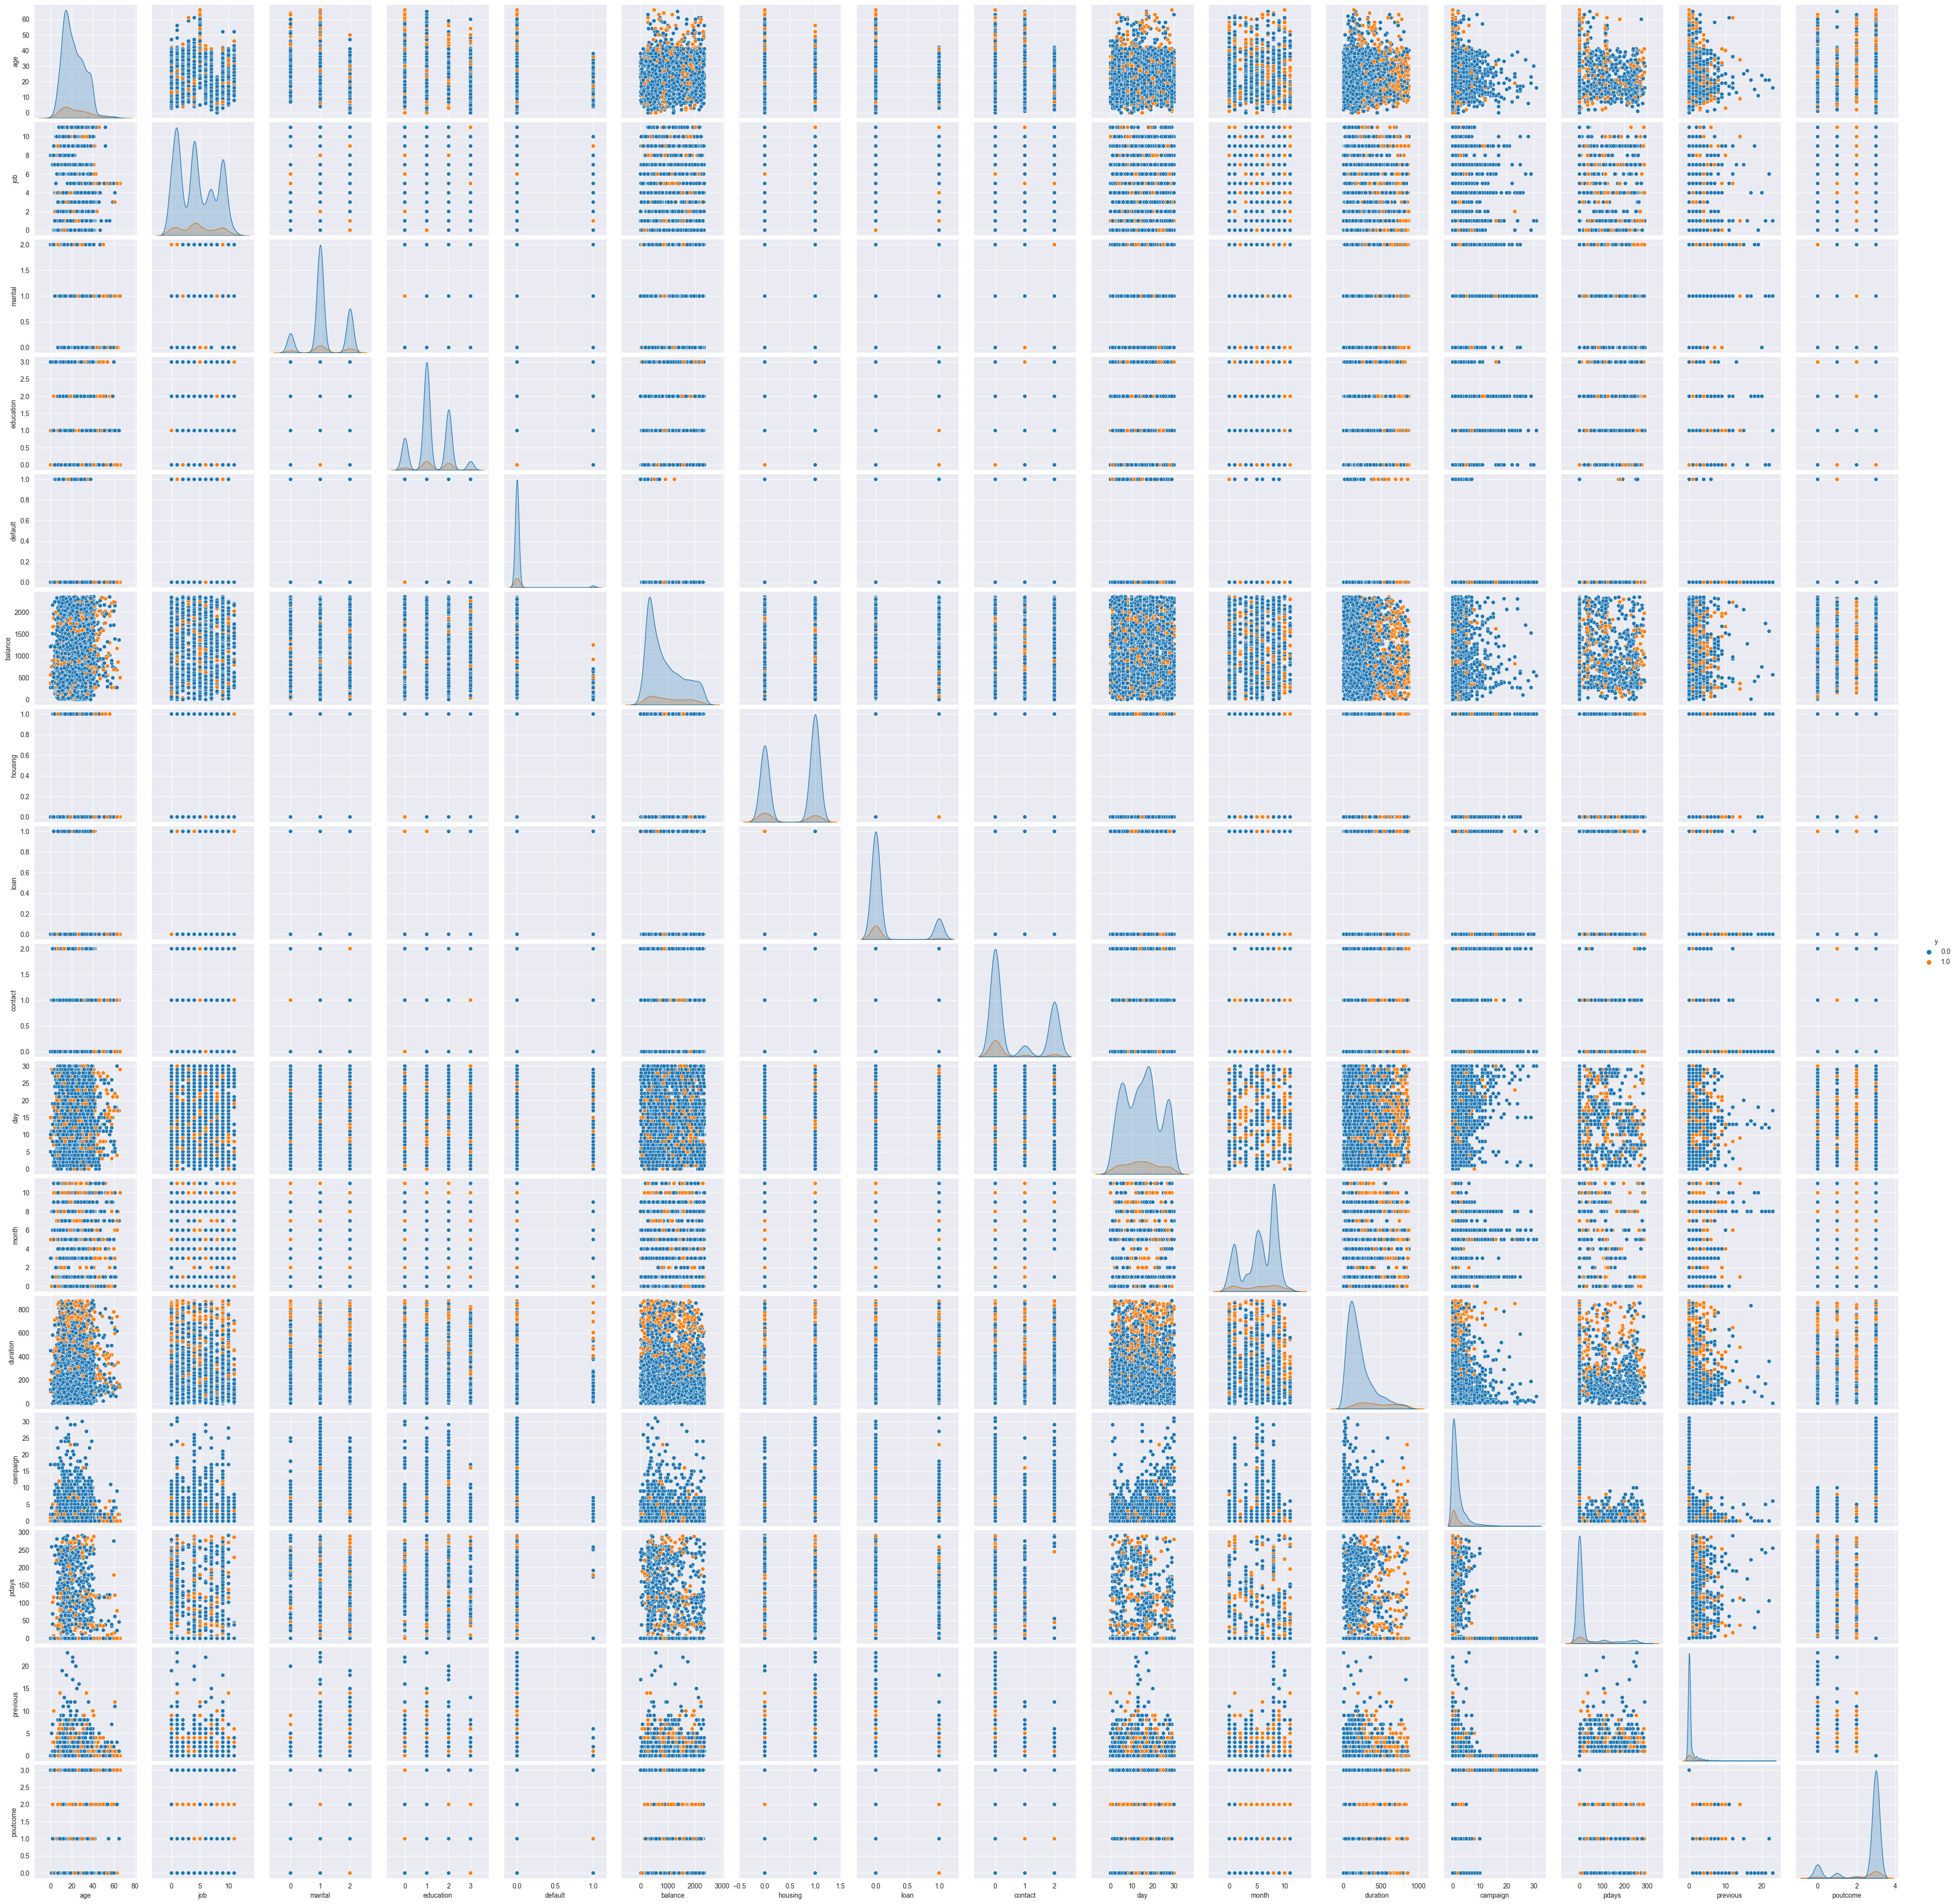

In [9]:
sns.pairplot(data_enc, hue='y')

<Axes: >

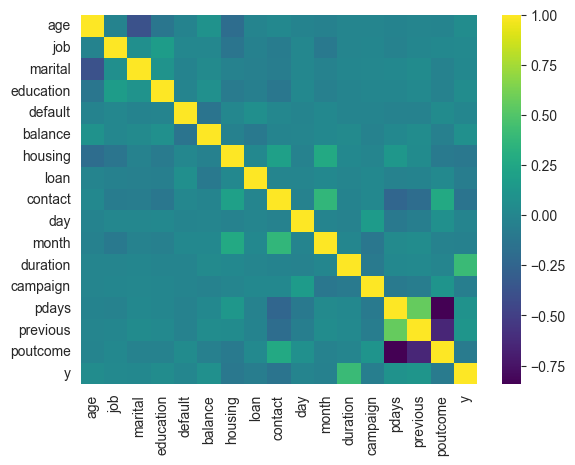

In [10]:
sns.heatmap(data_enc.corr(), cmap="viridis")

## Fairness exploration

In [11]:
protected_attributes = ['age', 'marital']

### Repartition exploration

In [13]:
# print sorted correlation to target
print(abs(data_enc.corr())['y'].sort_values(ascending=False))

y            1.000000
duration     0.406754
contact      0.133595
previous     0.119566
housing      0.104683
pdays        0.086057
poutcome     0.082632
balance      0.074867
loan         0.070517
campaign     0.062193
age          0.044866
education    0.042987
month        0.040933
job          0.027401
marital      0.015042
day          0.011244
default      0.001303
Name: y, dtype: float64


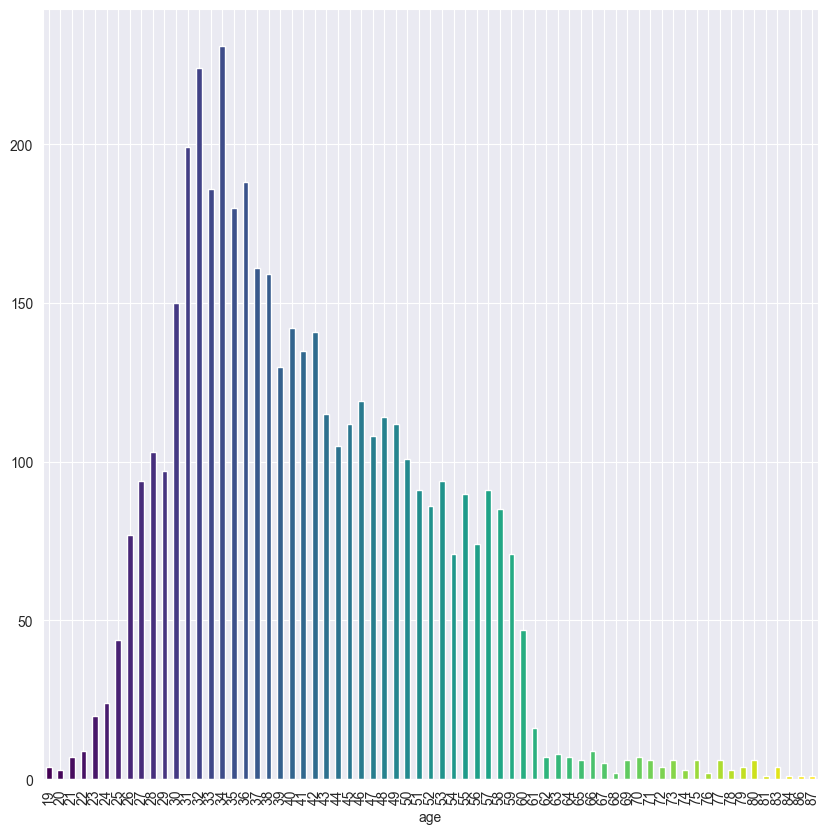

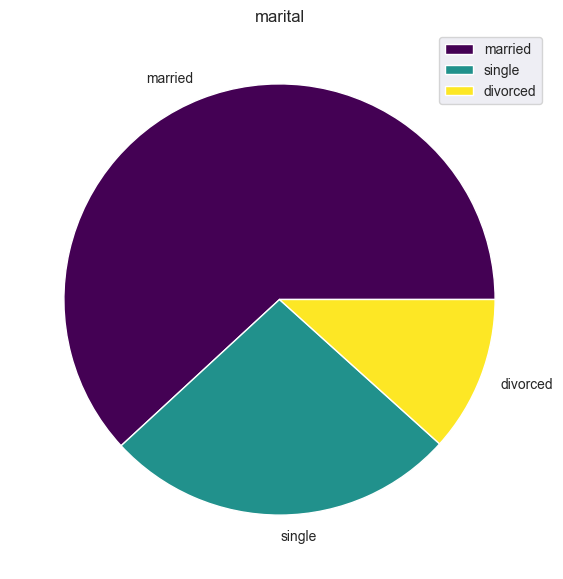

In [42]:
# plot protected attributes classes repartition
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
data.age.value_counts().sort_index().plot(kind='bar', color=cm.viridis(np.linspace(0, 1, len(data.age.value_counts()))))

plt.figure(figsize=(7,7))
plt.pie(data.marital.value_counts(), labels=data.marital.unique(), colors=cm.viridis(np.linspace(0, 1, len(data.marital.value_counts()))))
plt.legend(loc='upper right', labels=data.marital.unique())
plt.title('marital')
bbox_to_anchor=(2.02, 1)

### K-Best Selection exploration

In [97]:
# First protected attribute to appear
for i in range(1, len(data.columns[:-1])):
    selector = SelectKBest(chi2, k=i)
    selector.fit_transform(data_enc.drop('y', axis=1), data.y)
    intersect = set(data.columns[:-1][selector.get_support()]).intersection(protected_attributes)
    if len(intersect) > 0:
        print(i, intersect)
        break

7 {'age'}


In [99]:
# compute onehot encoded and rescaled dataset
data_oh = data.copy()
enc = OneHotEncoder(sparse_output=False)
columns_to_one_hot = data_oh.select_dtypes('object').columns[:-1]
encoded_array = enc.fit_transform(data_oh.loc[:,columns_to_one_hot])
data_encoded = pd.DataFrame(encoded_array,columns=enc.get_feature_names_out() )
data_encoded = pd.concat([data_oh,data_encoded],axis=1)
data_encoded.drop(labels= columns_to_one_hot,axis=1,inplace=True)

protected_attributes = ['age', 'marital_married', 'marital_single', 'marital_divorced']

scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(data_encoded.drop('y', axis=1)), columns=data_encoded.columns[:-1])

In [100]:
def cloud(word_list) :
    """
    Draw a WordCloud with a list of word
    :param word_list: list of string, first one => most important, last one => less important
    :return:
    """
    words = [word.replace(" ", "") for word in word_list[::-1]]
    freq = {mot: i+1 for i, mot in enumerate(words)}

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=plt.cm.viridis)

    wordcloud.generate_from_frequencies(freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [101]:
old_intersect = []
order = []
for i in range(1, len(scaled_data.columns[:-1])):
    selector = SelectKBest(chi2, k=i)
    selector.fit_transform(scaled_data, scaled_data.y)
    intersect = set(scaled_data.columns[selector.get_support()]).intersection(protected_attributes)
    if len(intersect) > len(old_intersect):
        order.append(list(set(intersect) - set(old_intersect))[0])
        old_intersect = intersect

In [106]:
old_intersect = []
order_full = []
for i in range(1, len(scaled_data.columns[:-1])):
    selector = SelectKBest(chi2, k=i)
    selector.fit_transform(scaled_data, scaled_data.y)
    intersect = set(scaled_data.columns[selector.get_support()]).intersection(scaled_data.columns)
    order_full.append(list(set(intersect) - set(old_intersect))[0])
    old_intersect = intersect

order_full.remove('y')

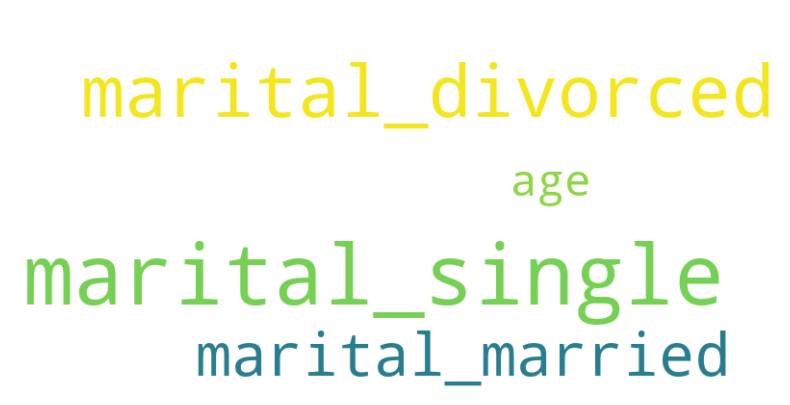

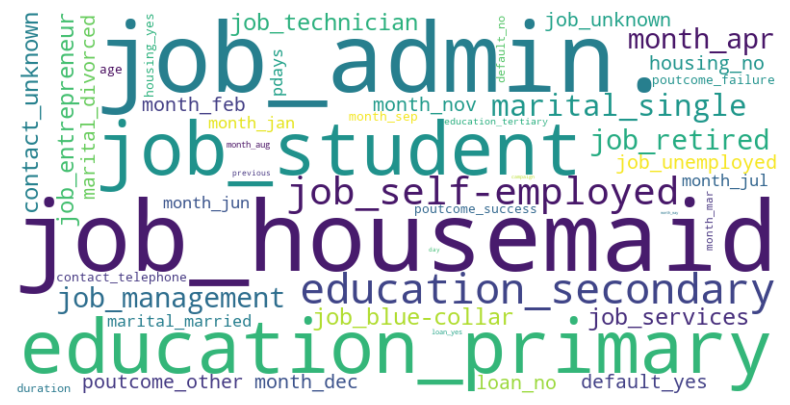

In [107]:
# print clouds
cloud(order)
cloud(order_full)